In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

# Constants

In [5]:
INPUT_DIM = 5 #50
BIAS = False

SEED = 42
N_TRAIN = 256
BATCH_SIZE = 64
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(1.5e3)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 2000

EPS = 1.0e-7
ALPHA = 0.1
BETA = 1.0
LAMBDA = 0.0 #0.01
TAU = 1.0

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/kernel_penalty_variants/')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

## Common functions

In [8]:
def forward(a, b, x):
    m = a.shape[1]
    if m == 0:
        return 0.
    return np.matmul(np.maximum(np.matmul(x, b.T), 0), a.T) #/ a.shape[1]

In [9]:
def H(c, u, kappa, sigma=1.0):
    if kappa == 'kappa_1':
        kappa = kappa_1
    elif kappa == 'kappa_2':
        kappa = kappa_2
    elif kappa == 'kappa_3':
        kappa = kappa_3
    else:
        kappa = kappa_1
    gram_mat = np.matmul(u, u.T)
    K = kappa(gram_mat, sigma=sigma)
    return 0.5 * np.matmul(np.abs(c), np.matmul(K, np.abs(c.T)))

In [10]:
def kappa_1(s, sigma=1.0):
    return 1 - np.exp((s - 1) / sigma**2)

In [11]:
def kappa_3(s, sigma=1.0):
    return np.exp((s - 1) / sigma**2)

### TODO
- Implement the 3 kernels

For both interactions with $\mu$ and $|\mu|$:
- Test with 2-20 particles and penalty only to understand the behaviour with penalty only
- Then test with full objective (tau=1) 

In [12]:
def projected_conic_update(x, y, c, u, kappa, sigma=1.0, conic=False):
    if kappa == 'kappa_1':
        grad_sign = -1.0
        kappa = kappa_1
    elif kappa == 'kappa_3':
        grad_sign = 1.0
        kappa = kappa_3
    else:
        grad_sign = 1.0
    signs = np.sign(c)    
    y_hat = forward(c, u, x)
    n = x.shape[0]
    
    gram_mat = np.matmul(u, u.T)
    K = kappa(gram_mat, sigma=sigma)
    
    # mass updates
    grad_H = np.matmul(np.abs(c), K)
    grad_J = np.matmul((y_hat - y).T, np.maximum(np.matmul(x, u.T), 0)) / n
    if conic:
        grad = TAU * signs * grad_J
    else:
        grad = TAU * signs * grad_J + LAMBDA * grad_H  # signs for the data-fitting term
    c = (1 - 2 * ETA * grad) * c  # no sign here since only the absolute values of the masses interact in the penalty
    
    # positions updates
    grad_H = grad_sign * (1 / sigma**2) * (np.matmul(np.abs(c) * K, u) - np.matmul(K * gram_mat, np.abs(c).T) * u)
    #grad_H = -(1 / sigma**2) * (np.matmul(c * K, u) - np.matmul(K * gram_mat, c.T) * u)
    #grad_H = (1 / sigma**2) * (np.matmul(np.abs(c) * K, u) - np.matmul(K * gram_mat, np.abs(c.T)) * u)
    grad_J = np.matmul(np.heaviside(np.matmul(u, x.T), 0), (y_hat - y)*x) / n
    if conic:
        grad = TAU * signs.T * grad_J
    else:
        grad = TAU * signs.T * grad_J + LAMBDA * grad_H
    u = u - ETA * grad
    
    # re-normalize particle positions on the sphere
    u = u / np.linalg.norm(u, axis=1, ord=2, keepdims=True)
    
    return c, u, grad

In [13]:
def remove_neurons(c, u, eps=1e-4):    
    mass_indexes_to_remove = np.argwhere(np.abs(c).reshape(-1) < eps)
    if len(mass_indexes_to_remove) > 0:
        u = np.delete(u, mass_indexes_to_remove, axis=0)
        c = np.delete(c, mass_indexes_to_remove, axis=1)
        
    squared_dists = 2 * (1 - np.matmul(u, u.T))  # vectors in u are of unit norm
    squared_dists += np.identity(len(squared_dists))
    dist_indexes_to_remove = np.argwhere(squared_dists < (eps**2))
    
    if len(dist_indexes_to_remove) > 0:
        cpt = 0
        i0, j = dist_indexes_to_remove[0]
        to_merge = {i0 : []}
        merged = set([i0])
        for k in range(len(dist_indexes_to_remove)):
            i, j = dist_indexes_to_remove[k]
            if i == i0:
                to_merge[i0].append(j)
                merged.add(j)
            else:
                if i not in merged:
                    i0 = i
                    merged.add(i)
                    to_merge[i] = []
                    if j not in merged:
                        to_merge[i].append(j)
                        merged.add(i)
                        merged.add(j)
        
        index_to_remove = []
        for i, js in to_merge.items():
            index_to_remove += js
            if len(js) > 0:
                c[0, i] += np.sum(c[0, js])

        u = np.delete(u, index_to_remove, axis=0)
        c = np.delete(c, index_to_remove, axis=1)
    
    return c, u

In [101]:
u_ = np.random.normal(size=(10, 5))
u_add = np.random.normal(size=(3, 5))
#np.hstack((u_, u_add)).shape
np.vstack((u_, u_add)).shape

(13, 5)

In [102]:
c_ = np.random.normal(size=(1, 10))
c_add = np.random.normal(size=(1, 3))
np.hstack((c_, c_add)).shape
#np.vstack((u_, u_add)).shape

(1, 13)

In [144]:
def add_neurons(c, u, x, y, kappa):
    curr_m = c.shape[1]
    if curr_m < m:
        new_u = np.random.normal(size=(m - curr_m, INPUT_DIM))
        new_u = new_u / np.linalg.norm(new_u, axis=1, ord=2, keepdims=True)
        
        if kappa == 'kappa_1':
            grad_sign = -1.0
            kappa = kappa_1
        elif kappa == 'kappa_3':
            grad_sign = 1.0
            kappa = kappa_3
        else:
            grad_sign = 1.0
        signs = np.sign(c)    
        y_hat = forward(c, u, x)
        n = x.shape[0]

        gram_mat = np.matmul(u, new_u.T)
        K = kappa(gram_mat, sigma=sigma)

        # mass updates
        grad_H = np.matmul(np.abs(c), K)
        grad_J = np.matmul((y_hat - y).T, np.maximum(np.matmul(x, new_u.T), 0)) / n

        grad = TAU * grad_J + LAMBDA * grad_H  # signs for the data-fitting term
        
        new_c = - grad
        
        #print('grad_H.shape', grad_H.shape)
        #print('grad_J.shape', grad_J.shape)
        #print('grad.shape', grad.shape)
        #print('new_c.shape', new_c.shape)
        
        c = np.hstack((c, new_c))
        u = np.vstack((u, new_u))
    return c, u

## Data

In [137]:
INPUT_DIM = 5
noise = 1e-5

m_star = 50
a_star = np.random.normal(size=(1, m_star))
b_star = np.random.normal(size=(m_star, INPUT_DIM)) / np.sqrt(INPUT_DIM)

n_train = 100
x_train = np.random.normal(size=(n_train, INPUT_DIM))
x_train = x_train / np.linalg.norm(x_train, axis=1, ord=2, keepdims=True)
y_train = forward(a_star, b_star, x_train) / m_star + noise * np.random.normal(size=(n_train, 1))

n_val = 50
x_val = np.random.normal(size=(n_val, INPUT_DIM))
x_val = x_val / np.linalg.norm(x_val, axis=1, ord=2, keepdims=True)
y_val = forward(a_star, b_star, x_val) / m_star + noise * np.random.normal(size=(n_val, 1))

## Training

In [170]:
def train(kappa, sigma=1.0, eps=1e-4, conic=False, c0=None, u0=None):
    if c0  is not None:
        c = c0
        signs = np.sign(c0)
    else:
        signs = np.sign(np.random.normal(size=(1, m)))    
        #signs = np.array([[1.0], 
        #                  #[1.0], 
        #                  [1.0]])#np.ones(shape=(m, 1))
        c = signs / m
    
    if u0 is not None:
        u = u0
    else:
        u = np.random.normal(size=(m, INPUT_DIM))
        u = u / np.linalg.norm(u, axis=1, ord=2, keepdims=True)
        #alpha = 29*np.pi / 60
        #beta = 39*np.pi / 80
        #u = np.array([[np.cos(alpha), np.sin(alpha)], 
        #              #[0., 1.0],
        #              [-np.cos(alpha), np.sin(alpha)]])
    
    us = [u]
    ms = [m]
    cs = [c]
    y_hat = forward(c, u, x_train)
    y_hats = [y_hat]
    
    
    loss = TAU * np.mean((y_hat - y_train)**2) /2
    losses = [loss]
    penalized_losses = [loss + LAMBDA * H(c, u, kappa, sigma)[0, 0]]
    grads = []
    
    mass = np.sqrt(m * np.abs(c))
    as_ = [signs * mass]
    bs = [mass.T * u]
    
    for k in range(N_STEPS):
        c, u, grad = projected_conic_update(x_train, y_train, c, u, kappa=kappa, sigma=sigma, conic=conic)
        y_hat = forward(c, u, x_train)
        
        c, u = remove_neurons(c, u, eps=eps)
        curr_m = c.shape[1]
        c, u = add_neurons(c, u, x_train, y_train, kappa)
        
        ms.append(c.shape[1])
        #a = a + ETA * grad_a_H(a, b, sigma)
        #b = b + ETA * grad_b_H(a, b, sigma)
        loss = TAU * np.mean((y_hat - y_train)**2) / 2
        penalized_loss = loss + LAMBDA * H(c, u, kappa, sigma)[0, 0]
        y_hats.append(y_hat)
        
        mass = np.sqrt(m * np.abs(c))
        
        cs.append(c)
        us.append(u)
        #as_.append(signs * mass)
        #bs.append(mass.T * u)
        losses.append(loss)
        penalized_losses.append(penalized_loss)
        grads.append(grad)
        
        
    #return np.array(cs), np.array(us), np.array(as_), np.array(bs), np.array(losses), np.array(grads), np.array(ms)
    return cs, us, np.array(losses), np.array(penalized_losses), grads, ms, y_hats

In [229]:
m = 100
ETA = 0.005
sigma = 0.1 #0.08
N_STEPS = 8000
eps = 4.0e-3

TAU = 1.0
ALPHA = 0.02

signs = np.sign(np.random.normal(size=(1, m)))

#signs = np.array([[1.0], 
#                  #[1.0], 
#                  [1.0]])#np.ones(shape=(m, 1))
c0 = signs / m


u0 = np.random.normal(size=(m, INPUT_DIM))
u0 = u0 / np.linalg.norm(u0, axis=1, ord=2, keepdims=True)

#c, u, losses, penalized_losses, grads, ms, _ = train(kappa='kappa_1', sigma=sigma, eps=eps)
LAMBDA = 0.3 #0.08
c3, u3, losses3, penalized_losses3, grads3, ms3, _ = train(kappa='kappa_3', sigma=sigma, eps=eps, c0=c0, u0=u0)
LAMBDA = 0.003 #0.0005
c1, u1, losses1, penalized_losses1, grads1, ms1, _ = train(kappa='kappa_1', sigma=sigma, eps=eps, c0=c0, u0=u0)

In [230]:
conic=True

c, u, losses, penalized_losses, grads, ms, _ = train(kappa='kappa_1', sigma=sigma, eps=eps, conic=conic, c0=c0, u0=u0)
#c3, u3, losses3, penalized_losses3, grads3, ms3, y_hat3 = train(kappa='kappa_3', sigma=sigma, eps=eps)
#c1, u1, losses1, penalized_losses1, grads1, ms1, y_hat1 = train(kappa='kappa_1', sigma=sigma, eps=eps)

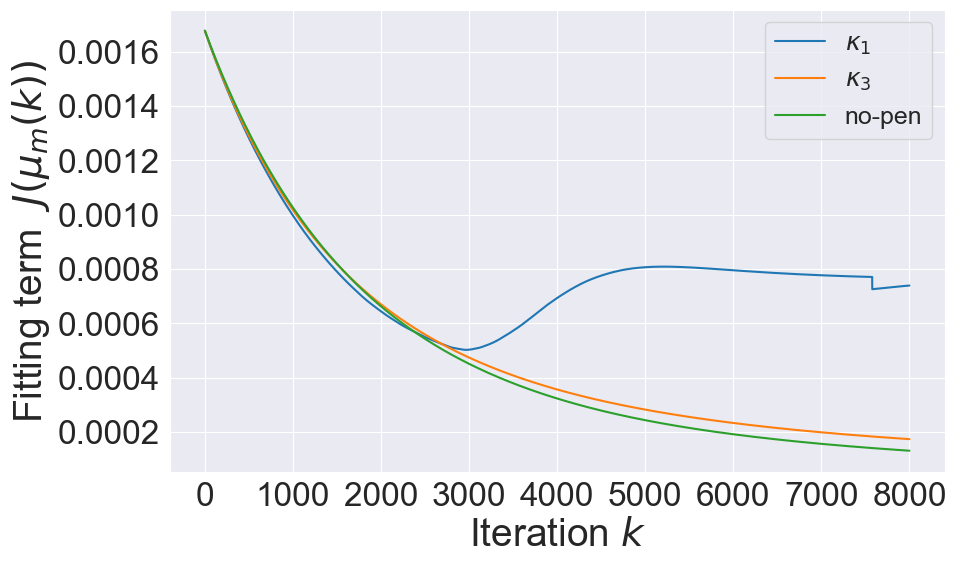

In [231]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(losses1)), losses1, label='$\\kappa_1$')
plt.plot(np.arange(len(losses3)), losses3, label='$\\kappa_3$')
plt.plot(np.arange(len(losses)), losses, label='no-pen')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Fitting term $\\ J(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

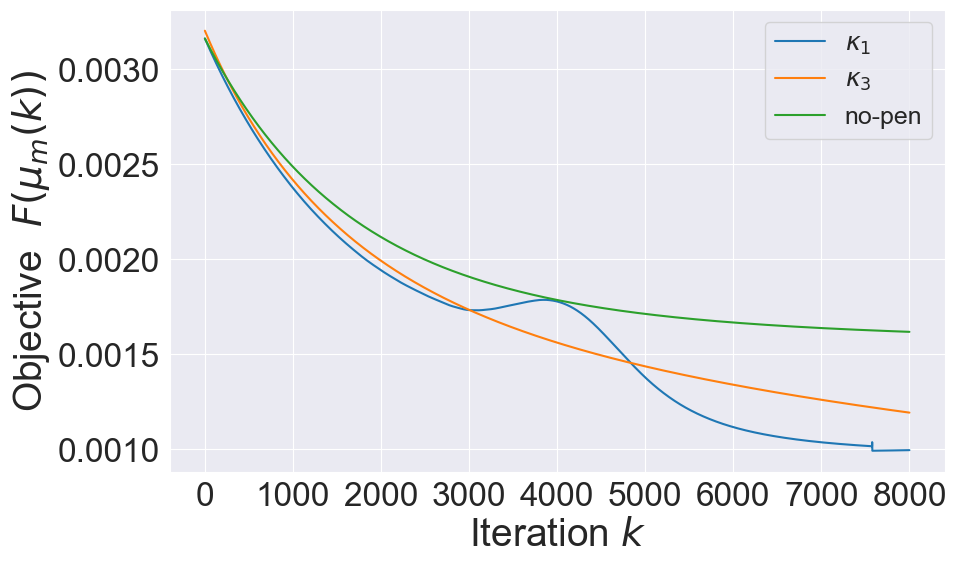

In [232]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_losses1)), penalized_losses1, label='$\\kappa_1$')
plt.plot(np.arange(len(penalized_losses3)), penalized_losses3, label='$\\kappa_3$')
plt.plot(np.arange(len(penalized_losses)), penalized_losses, label='no-pen')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective $\\ F(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

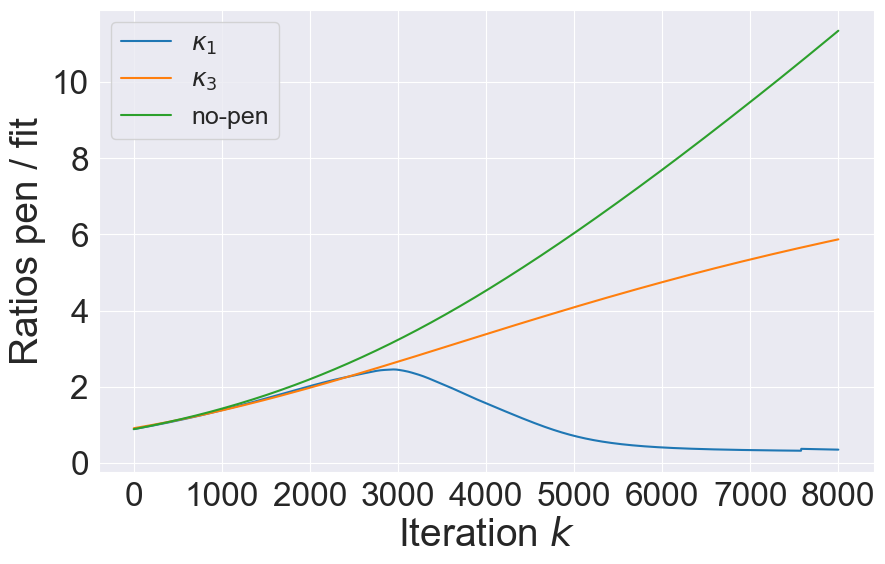

In [233]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

penalties = penalized_losses - losses
penalties1 = penalized_losses1 - losses1
penalties3 = penalized_losses3 - losses3

ratios = penalties / losses
ratios1 = penalties1 / losses1
ratios3 = penalties3 / losses3

plt.plot(np.arange(len(ratios1)), ratios1, label='$\\kappa_1$')
plt.plot(np.arange(len(ratios3)), ratios3, label='$\\kappa_3$')
plt.plot(np.arange(len(ratios)), ratios, label='no-pen')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Ratios pen / fit', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

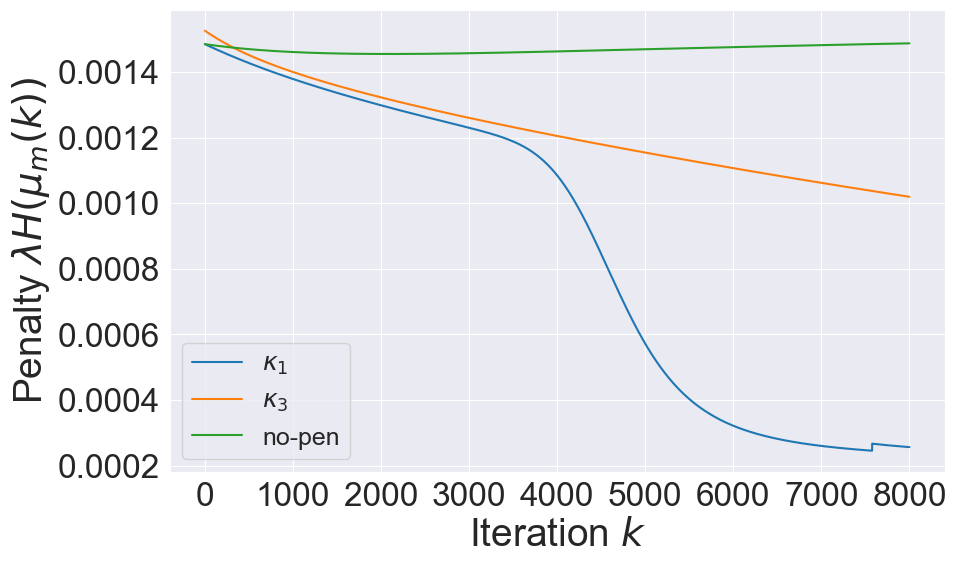

In [234]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalties1)), penalties1, label='$\\kappa_1$')
plt.plot(np.arange(len(penalties3)), penalties3, label='$\\kappa_3$')
plt.plot(np.arange(len(penalties)), penalties, label='no-pen')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalty $\\lambda H(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

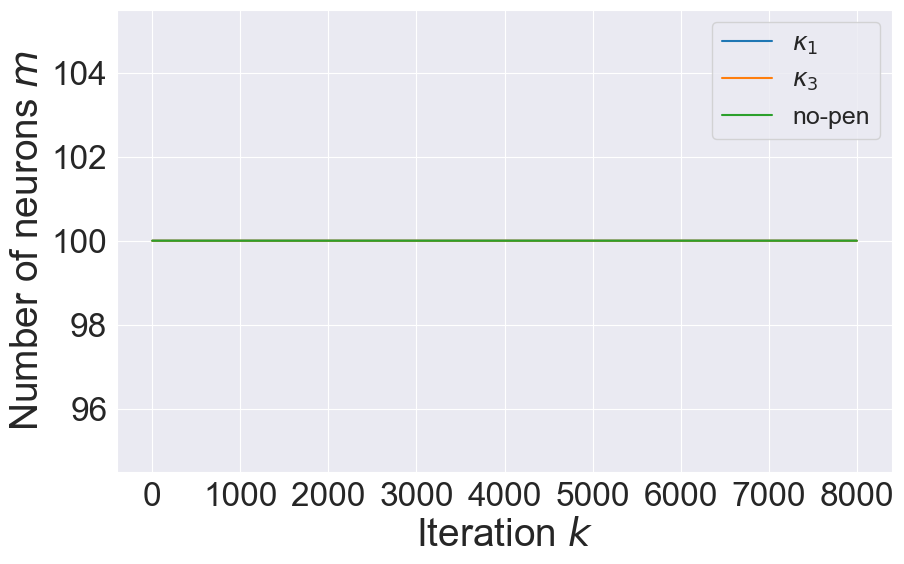

In [228]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms1)), ms1, label='$\\kappa_1$')
plt.plot(np.arange(len(ms3)), ms3, label='$\\kappa_3$')
plt.plot(np.arange(len(ms)), ms, label='no-pen')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Number of neurons $m$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

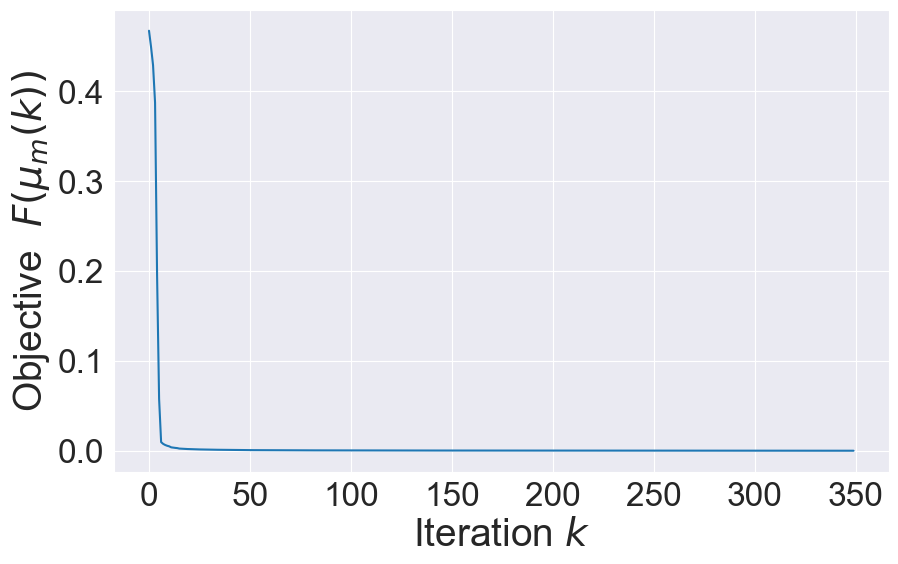

In [190]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')
n_iter = 350

plt.plot(np.arange(len(penalized_losses))[:n_iter], penalized_losses[:n_iter])

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective $\\ F(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

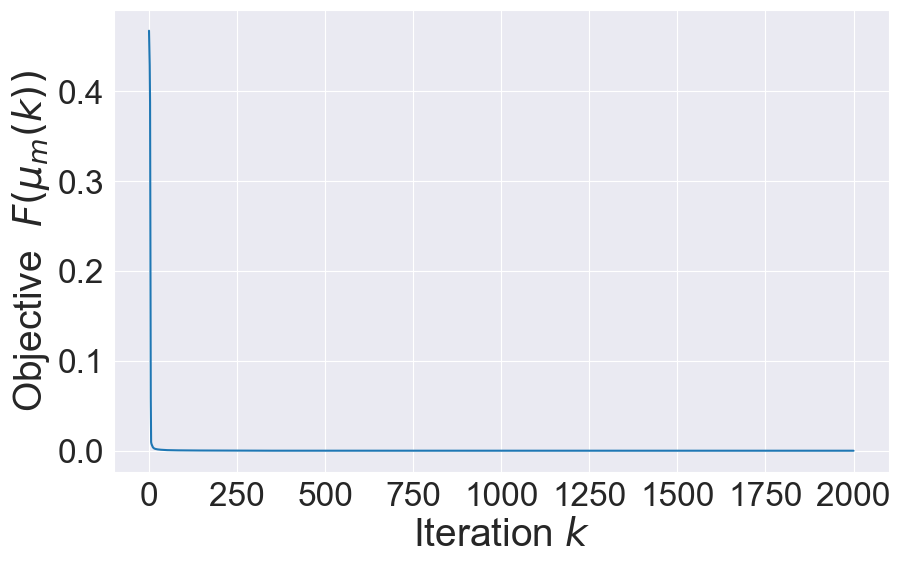

In [191]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_losses)), penalized_losses)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective $\\ F(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

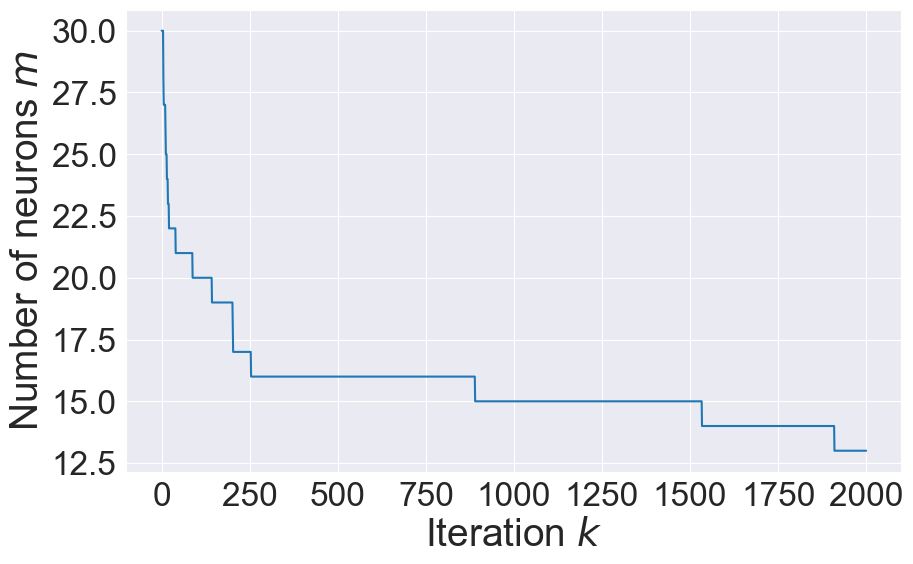

In [192]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Number of neurons $m$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

In [217]:
c, u = c1, u1
#c, u = c3, u3

In [209]:
signs = [np.sign(c_[0, :]) for c_ in c]
pos = [signs_ > 0 for signs_ in signs]
neg = [signs_ < 0 for signs_ in signs]

u_pos = [u[k][pos[k], :] for k in range(len(u))]
u_neg = [u[k][neg[k], :] for k in range(len(u))]

In [210]:
def plot_2d(k):
    plt.figure(figsize=(6, 6))
    marker = None #'o'
    #plt.xscale('log')
    #plt.yscale('log')
    marker = 'o'

    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)

    plt.scatter(u_pos[k][:, 0], u_pos[k][:, 1], marker=marker, s=30.0, label='$+$')
    plt.scatter(u_neg[k][:, 0], u_neg[k][:, 1], marker=marker, s=30.0, label='$-$')
    #plt.scatter(b_neg[k, :, 0], -0.5*np.ones(len(b_neg[k, :, 0])), marker=marker, s=30.0, label='$-$')

    #plt.xlabel('Particle positions', fontsize=28)
    #plt.ylabel('Pos / Neg', fontsize=28)
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xticks([])
    plt.yticks([])
    #plt.yticks(fontsize=24)
    plt.legend(fontsize=18)
    #plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
    plt.show()

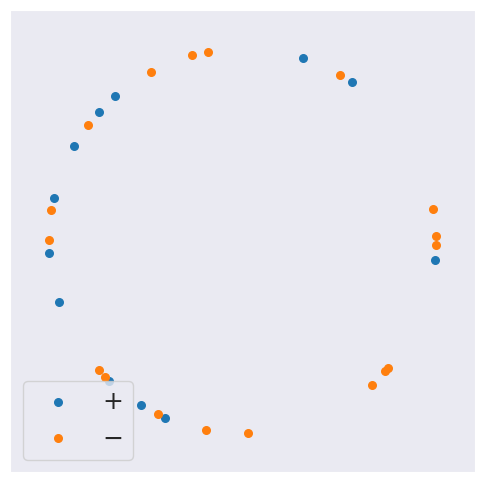

In [211]:
plot_2d(k=0)

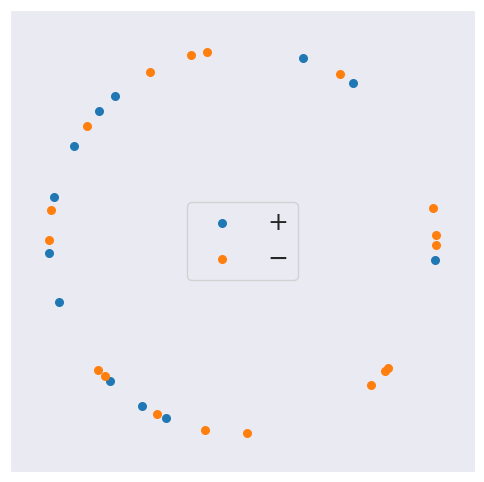

In [212]:
plot_2d(k=10)

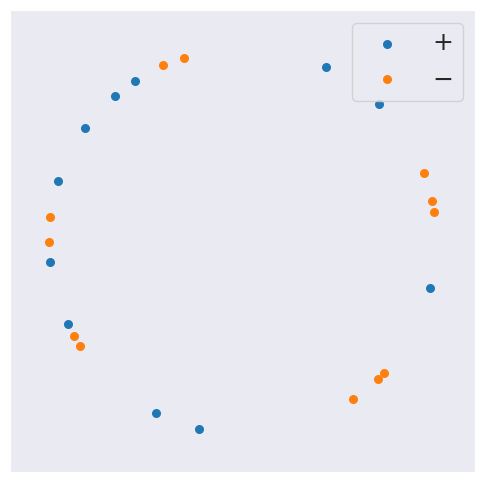

In [213]:
plot_2d(k=1400)

In [75]:
def f(s, sigma=0.08):
    #return np.maximum(0, 1 - np.sqrt(2 * (1 - s) ))**2
    return np.maximum(0,  1 - s/sigma)**2

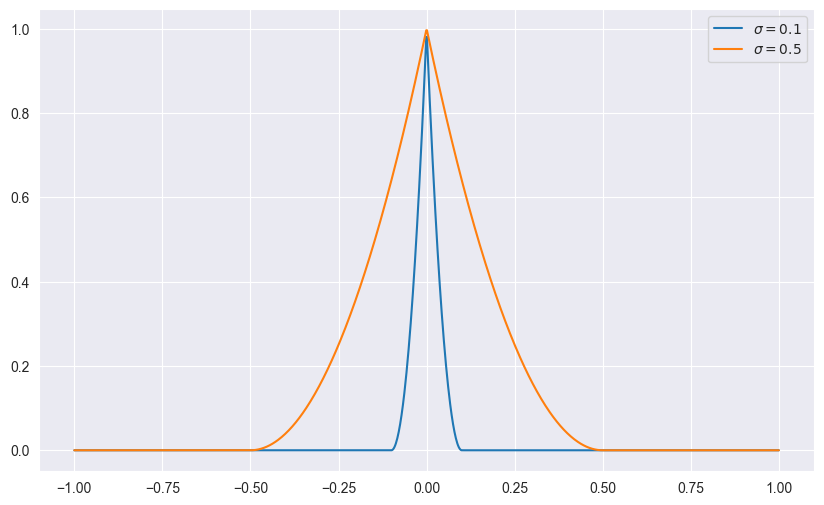

In [82]:
plt.figure(figsize=(10, 6))

xs = np.linspace(start=-1., stop=1.0, num=1000, endpoint=True)
#sigmas = [0.001, 0.005, 0.01, 0.05, 0.08, 1.0]
sigmas = [0.1, 0.5]
for sigma in sigmas:
    #ys = f(xs, sigma)
    ys = [np.maximum(0, 1 - (np.abs(x) / sigma))**2 for x in xs]
    plt.plot(xs, ys, label='$\\sigma={}$'.format(sigma))

plt.legend()
plt.show()